# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_148  H3BM42;Q92896;Q92896-2;Q92896-3   13.561
Sample_112  Q9NZ53                            17.007
Sample_052  O43916                            13.875
Sample_147  Q8NFP4;Q8NFP4-2                   15.908
Sample_083  P43121                            17.408
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups               
Sample_150  Q14766                          14.653
Sample_071  Q9UFP1                          13.441
Sample_198  B1AJZ9;B1AJZ9-4;H0YE38;Q5JYW6   10.882
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.672
            A0A075B6Q5                 13.011
            A0A075B6R2                 13.739
            A0A075B6S5                 13.417
            A0A087WSY4                 12.306
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.543
            Q9UI40;Q9UI40-2            13.227
            Q9UIW2                     12.073
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.727
            Q9UP79                     12.606
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.161,15.050,16.842,19.863,12.988,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.521,19.067,...,15.528,15.576,12.367,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.748,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.537,17.705,17.039,13.573,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.534,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.952,15.345,17.084,18.708,14.249,19.433,8.245,9.957
Sample_207,15.739,16.877,15.469,16.898,10.639,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.672,...,16.012,15.178,12.711,15.050,16.842,19.863,11.810,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.106,19.067,16.188,...,15.528,15.576,13.939,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.751,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.939,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.922,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.998,15.345,17.084,18.708,14.249,19.433,13.204,11.321
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.99it/s]

100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.39it/s]

100%|██████████| 4/4 [00:00<00:00,  3.92it/s]

100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.97it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.49it/s]

100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.26it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.54it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.67it/s]

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.38it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.14it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.70it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.57it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.42it/s]

100%|██████████| 7/7 [00:01<00:00,  3.36it/s]

100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.28it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.38it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.79it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.93it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.97it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.62it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.79it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.68it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.85it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.99it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.05it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.10it/s]

100%|██████████| 9/9 [00:02<00:00,  3.17it/s]

100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.03it/s]

 30%|███       | 3/10 [00:00<00:01,  3.51it/s]

 40%|████      | 4/10 [00:01<00:01,  3.17it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.28it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.31it/s]

100%|██████████| 10/10 [00:02<00:00,  3.26it/s]

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.50it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.44it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.45it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.39it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.34it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.35it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.21it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.16it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.21it/s]

100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.59it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.41it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.33it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.11it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.12it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.17it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.22it/s]

100%|██████████| 12/12 [00:03<00:00,  2.80it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.10it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.37it/s]

 31%|███       | 4/13 [00:00<00:02,  3.87it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.69it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.48it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.44it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.31it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.30it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.32it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.98it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.51it/s]

100%|██████████| 13/13 [00:04<00:00,  2.18it/s]

100%|██████████| 13/13 [00:04<00:00,  2.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.10it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.41it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.62it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.13it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.16it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.23it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.68it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.29it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.12it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.10it/s]

100%|██████████| 14/14 [00:05<00:00,  2.25it/s]

100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.52it/s]

 20%|██        | 3/15 [00:00<00:02,  4.40it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.73it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.56it/s]

 40%|████      | 6/15 [00:01<00:02,  3.44it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.37it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.16it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.08it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.78it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.47it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.23it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.06it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.20it/s]

100%|██████████| 15/15 [00:05<00:00,  2.25it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.075 0.034          0.711 0.396       0.103   
2             0.006 0.005      0.064 0.025          0.687 0.088       0.624   
3             0.004 0.003      0.058 0.017          0.765 0.101       0.720   
4             0.006 0.005      0.071 0.026          0.769 0.096       0.762   
5             0.004 0.000      0.057 0.020          0.765 0.097       0.760   
6             0.006 0.005      0.066 0.026          0.805 0.083       0.782   
7             0.005 0.005      0.069 0.033          0.806 0.084       0.767   
8             0.005 0.003      0.064 0.023          0.811 0.085       0.778   
9             0.006 0.005      0.062 0.024          0.797 0.086       0.791   
10            0.006 0.004      0.065 0.023          0.793 0.081       0.790   
11            0.005 0.004      0.064 0.024          0.793 0.084       0.792   
12            0.007 0.005      0.066 0.025          0.787 0.077       0.803   
13            0.006 0.004      0.058 0.018          0.785 0.078       0.803   
14            0.005 0.003      0.063 0.022          0.791 0.085       0.825   
15            0.005 0.003      0.058 0.022          0.804 0.082       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.173 0.131                  0.544 0.042        0.857   
2          0.113   0.647 0.080                  0.706 0.059        0.795   
3          0.101   0.736 0.076                  0.776 0.061        0.878   
4          0.108   0.758 0.072                  0.794 0.059        0.879   
5          0.105   0.757 0.073                  0.792 0.061        0.876   
6          0.097   0.789 0.069                  0.820 0.057        0.895   
7          0.098   0.782 0.072                  0.815 0.059        0.895   
8          0.100   0.789 0.072                  0.821 0.059        0.893   
9          0.106   0.789 0.074                  0.820 0.063        0.907   
10         0.106   0.787 0.074                  0.819 0.062        0.905   
11         0.108   0.788 0.077                  0.820 0.064        0.903   
12         0.100   0.791 0.070                  0.821 0.059        0.902   
13         0.100   0.790 0.070                  0.820 0.059        0.901   
14         0.096   0.804 0.069                  0.832 0.059        0.905   
15         0.098   0.806 0.068                  0.834 0.058        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.819 0.083        210.000 0.000  
2          0.064                  0.749 0.084        210.000 0.000  
3          0.052                  0.836 0.075        210.000 0.000  
4          0.051                  0.836 0.074        210.000 0.000  
5          0.052                  0.833 0.074        210.000 0.000  
6          0.048                  0.863 0.067        210.000 0.000  
7          0.049                  0.863 0.069        210.000 0.000  
8          0.050                  0.859 0.070        210.000 0.000  
9          0.046                  0.888 0.055        210.000 0.000  
10         0.047                  0.885 0.056        210.000 0.000  
11         0.049                  0.883 0.058        210.000 0.000  
12         0.049                  0.883 0.057        210.000 0.000  
13         0.049                  0.883 0.056        210.000 0.000  
14         0.048                  0.888 0.054        210.000 0.000  
15         0.046                  0.895 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 447.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.32it/s]

100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.56it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.32it/s]

100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.79it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.43it/s]

100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.80it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.99it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.25it/s]

100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.34it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.99it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.95it/s]

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.46it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.50it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.77it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.05it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.22it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.07it/s]

100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.94it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.24it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.17it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.03it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.01it/s]

100%|██████████| 9/9 [00:03<00:00,  1.90it/s]

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.85it/s]

 30%|███       | 3/10 [00:00<00:01,  3.57it/s]

 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.13it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.99it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.94it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.73it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.31it/s]

100%|██████████| 10/10 [00:03<00:00,  2.10it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.80it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.98it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.49it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.05it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.35it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.97it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.80it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.61it/s]

100%|██████████| 11/11 [00:05<00:00,  1.69it/s]

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.75it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.93it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.29it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.04it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.03it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.26it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.31it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.29it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.94it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.89it/s]

100%|██████████| 12/12 [00:05<00:00,  1.85it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.60it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.06it/s]

 31%|███       | 4/13 [00:01<00:02,  3.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.94it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.72it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.77it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.85it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.55it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.28it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.07it/s]

100%|██████████| 13/13 [00:05<00:00,  2.08it/s]

100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.24it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.83it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.26it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.02it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.90it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.79it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.66it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.38it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.37it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.97it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.70it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.70it/s]

100%|██████████| 14/14 [00:06<00:00,  1.73it/s]

100%|██████████| 14/14 [00:06<00:00,  2.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.80it/s]

 20%|██        | 3/15 [00:00<00:02,  4.08it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.34it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.35it/s]

 40%|████      | 6/15 [00:02<00:04,  2.20it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.03it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.81it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.70it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.70it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.65it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.81it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.86it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.94it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

100%|██████████| 15/15 [00:07<00:00,  2.06it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.067 0.030          0.789 0.321       0.134   
2             0.006 0.004      0.074 0.030          0.699 0.093       0.605   
3             0.006 0.006      0.084 0.033          0.673 0.096       0.600   
4             0.005 0.004      0.068 0.023          0.695 0.090       0.670   
5             0.005 0.004      0.058 0.020          0.743 0.084       0.709   
6             0.005 0.004      0.063 0.023          0.748 0.091       0.725   
7             0.006 0.005      0.064 0.024          0.742 0.091       0.722   
8             0.006 0.004      0.079 0.031          0.739 0.095       0.725   
9             0.005 0.004      0.062 0.024          0.744 0.098       0.732   
10            0.007 0.005      0.075 0.029          0.799 0.098       0.779   
11            0.004 0.002      0.055 0.018          0.792 0.101       0.776   
12            0.004 0.000      0.056 0.020          0.804 0.099       0.804   
13            0.007 0.005      0.072 0.031          0.809 0.094       0.812   
14            0.007 0.007      0.064 0.026          0.845 0.078       0.834   
15            0.007 0.008      0.053 0.017          0.845 0.081       0.830   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.221 0.131                  0.559 0.044        0.852   
2          0.106   0.642 0.081                  0.705 0.061        0.786   
3          0.105   0.627 0.079                  0.690 0.061        0.780   
4          0.110   0.675 0.073                  0.724 0.059        0.784   
5          0.120   0.721 0.087                  0.764 0.068        0.851   
6          0.109   0.732 0.080                  0.772 0.066        0.856   
7          0.113   0.727 0.083                  0.768 0.068        0.856   
8          0.122   0.727 0.090                  0.768 0.074        0.859   
9          0.127   0.732 0.094                  0.773 0.076        0.866   
10         0.107   0.784 0.084                  0.816 0.069        0.906   
11         0.106   0.779 0.082                  0.811 0.068        0.904   
12         0.106   0.799 0.082                  0.828 0.069        0.911   
13         0.112   0.805 0.084                  0.834 0.071        0.915   
14         0.106   0.835 0.075                  0.860 0.064        0.919   
15         0.102   0.834 0.075                  0.858 0.064        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.087        210.000 0.000  
2          0.066                  0.761 0.085        210.000 0.000  
3          0.066                  0.748 0.082        210.000 0.000  
4          0.065                  0.744 0.087        210.000 0.000  
5          0.056                  0.812 0.070        210.000 0.000  
6          0.057                  0.823 0.069        210.000 0.000  
7          0.057                  0.822 0.071        210.000 0.000  
8          0.060                  0.822 0.075        210.000 0.000  
9          0.058                  0.826 0.077        210.000 0.000  
10         0.050                  0.890 0.054        210.000 0.000  
11         0.051                  0.888 0.055        210.000 0.000  
12         0.048                  0.894 0.052        210.000 0.000  
13         0.048                  0.897 0.053        210.000 0.000  
14         0.048                  0.908 0.049        210.000 0.000  
15         0.048                  0.909 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 967.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.84it/s]

100%|██████████| 2/2 [00:00<00:00, 18.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.03it/s]

100%|██████████| 3/3 [00:00<00:00, 16.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.19it/s]

100%|██████████| 4/4 [00:00<00:00, 14.29it/s]

100%|██████████| 4/4 [00:00<00:00, 14.70it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.69it/s]

100%|██████████| 5/5 [00:00<00:00, 16.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 13.79it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.00it/s]

100%|██████████| 6/6 [00:00<00:00, 11.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.30it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.42it/s]

100%|██████████| 7/7 [00:00<00:00, 13.97it/s]

100%|██████████| 7/7 [00:00<00:00, 14.57it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.74it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.80it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.94it/s]

100%|██████████| 8/8 [00:00<00:00, 10.55it/s]

100%|██████████| 8/8 [00:00<00:00, 11.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.98it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.47it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.17it/s]

100%|██████████| 9/9 [00:00<00:00, 12.56it/s]

100%|██████████| 9/9 [00:00<00:00, 12.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.35it/s]

 40%|████      | 4/10 [00:00<00:00, 10.05it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.31it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.03it/s]

 90%|█████████ | 9/10 [00:00<00:00,  8.97it/s]

100%|██████████| 10/10 [00:01<00:00,  8.98it/s]

100%|██████████| 10/10 [00:01<00:00,  9.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.94it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.58it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.65it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.08it/s]

100%|██████████| 11/11 [00:00<00:00, 11.19it/s]

100%|██████████| 11/11 [00:00<00:00, 12.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.58it/s]

 42%|████▏     | 5/12 [00:00<00:00, 16.20it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.82it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.89it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.88it/s]

100%|██████████| 12/12 [00:00<00:00, 14.47it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.71it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.84it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.47it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.61it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.43it/s]

100%|██████████| 13/13 [00:01<00:00, 12.22it/s]

100%|██████████| 13/13 [00:01<00:00, 12.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 13.76it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.92it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.86it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.02it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.30it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.33it/s]

100%|██████████| 14/14 [00:01<00:00, 11.71it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.59it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.80it/s]

 40%|████      | 6/15 [00:00<00:00, 10.38it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.94it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.45it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.29it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.90it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.68it/s]

100%|██████████| 15/15 [00:01<00:00,  8.92it/s]

100%|██████████| 15/15 [00:01<00:00,  9.56it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.066 0.026          0.000 0.000       0.000   
2             0.004 0.002      0.049 0.011          0.053 0.217       0.008   
3             0.006 0.006      0.062 0.021          0.236 0.300       0.036   
4             0.004 0.002      0.051 0.010          0.577 0.108       0.359   
5             0.005 0.003      0.062 0.021          0.543 0.108       0.354   
6             0.004 0.002      0.058 0.021          0.533 0.122       0.343   
7             0.005 0.005      0.059 0.023          0.534 0.091       0.350   
8             0.004 0.002      0.063 0.025          0.531 0.105       0.371   
9             0.004 0.000      0.048 0.005          0.518 0.111       0.361   
10            0.004 0.002      0.053 0.017          0.521 0.093       0.381   
11            0.006 0.004      0.062 0.021          0.501 0.096       0.367   
12            0.006 0.004      0.064 0.025          0.522 0.111       0.421   
13            0.006 0.008      0.066 0.033          0.520 0.109       0.414   
14            0.005 0.005      0.051 0.011          0.517 0.106       0.419   
15            0.004 0.001      0.052 0.018          0.507 0.085       0.421   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.700   
2          0.038   0.013 0.059                  0.503 0.014        0.646   
3          0.046   0.061 0.074                  0.497 0.021        0.643   
4          0.091   0.435 0.083                  0.580 0.051        0.623   
5          0.099   0.421 0.091                  0.566 0.055        0.613   
6          0.098   0.410 0.092                  0.558 0.059        0.597   
7          0.098   0.417 0.091                  0.564 0.052        0.593   
8          0.103   0.431 0.094                  0.565 0.062        0.594   
9          0.104   0.419 0.099                  0.557 0.064        0.587   
10         0.088   0.434 0.079                  0.559 0.055        0.603   
11         0.084   0.418 0.077                  0.546 0.057        0.588   
12         0.114   0.457 0.095                  0.566 0.065        0.623   
13         0.110   0.453 0.094                  0.565 0.063        0.614   
14         0.109   0.453 0.084                  0.561 0.056        0.607   
15         0.105   0.452 0.080                  0.559 0.054        0.597   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.679 0.077        210.000 0.000  
2          0.098                  0.622 0.099        210.000 0.000  
3          0.094                  0.587 0.109        210.000 0.000  
4          0.078                  0.597 0.073        210.000 0.000  
5          0.078                  0.587 0.074        210.000 0.000  
6          0.079                  0.575 0.076        210.000 0.000  
7          0.068                  0.573 0.065        210.000 0.000  
8          0.072                  0.568 0.071        210.000 0.000  
9          0.075                  0.563 0.075        210.000 0.000  
10         0.067                  0.552 0.068        210.000 0.000  
11         0.067                  0.535 0.069        210.000 0.000  
12         0.071                  0.577 0.079        210.000 0.000  
13         0.067                  0.566 0.080        210.000 0.000  
14         0.064                  0.562 0.072        210.000 0.000  
15         0.062                  0.554 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,14,12
score_time,1,3,1
test_precision,8,14,4
test_recall,14,14,12
test_f1,15,14,12
test_balanced_accuracy,15,14,4
test_roc_auc,15,15,1
test_average_precision,15,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.23it/s]

 20%|██        | 3/15 [00:00<00:03,  3.05it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.65it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.52it/s]

 40%|████      | 6/15 [00:02<00:03,  2.43it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.02it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.01it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.93it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.93it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.14it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.20it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.27it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.29it/s]

100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 978.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.39it/s]

 20%|██        | 3/15 [00:00<00:03,  3.47it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.83it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.64it/s]

 40%|████      | 6/15 [00:02<00:03,  2.43it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.58it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.71it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.57it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.43it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.35it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.32it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.39it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.46it/s]

100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


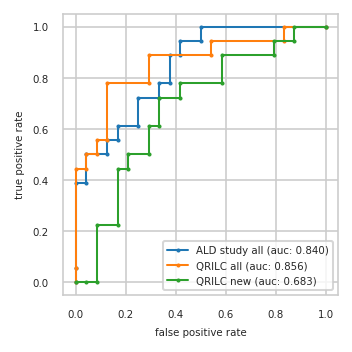

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.389     0.000 0.444     0.083 0.000
3          0.042 0.389     0.042 0.444     0.083 0.222
4          0.042 0.500     0.042 0.500     0.167 0.222
5          0.125 0.500     0.083 0.500     0.167 0.444
6          0.125 0.556     0.083 0.556     0.208 0.444
7          0.167 0.556     0.125 0.556     0.208 0.500
8          0.167 0.611     0.125 0.778     0.292 0.500
9          0.250 0.611     0.292 0.778     0.292 0.611
10         0.250 0.722     0.292 0.889     0.333 0.611
11         0.333 0.722     0.542 0.889     0.333 0.722
12         0.333 0.778     0.542 0.944     0.417 0.722
13         0.375 0.778     0.833 0.944     0.417 0.778
14         0.375 0.889     0.833 1.000     0.583 0.778
15         0.417 0.889     1.000 1.000     0.583 0.889
16         0.417 0.944       NaN   NaN     0.792 0.889
17         0.500 0.944       NaN   NaN     0.792 0.944
18         0.500 1.000       NaN   NaN     0.875 0.944
19         1.000 1.000       NaN   NaN     0.875 1.000
20           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,A0A0J9YX35,None
2,O76061,P15151-2,None
3,A0A0A0MRJ7;P12259,P61981,None
4,P61981,Q9Y2T3;Q9Y2T3-3,None
5,P14174,P14174,None
6,P04075,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None
7,C9JF17;P05090,P04075,None
8,P00338;P00338-3,P05413;S4R371,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


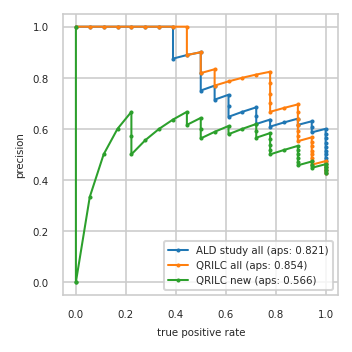

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.459 0.944     0.459 0.944
6          0.500 1.000     0.472 0.944     0.472 0.944
7          0.514 1.000     0.486 0.944     0.457 0.889
8          0.529 1.000     0.500 0.944     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.586 0.944     0.552 0.889     0.517 0.833
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.625 0.833     0.667 0.889     0.583 0.778
19         0.609 0.778     0.696 0.889     0.565 0.722
20         0.636 0.778     0.682 0.833     0.591 0.722
21         0.619 0.722     0.667 0.778     0.619 0.722
22         0.650 0.722     0.700 0.778     0.600 0.667
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.667 0.667     0.778 0.778     0.611 0.611
25         0.647 0.611     0.824 0.778     0.588 0.556
26         0.688 0.611     0.812 0.722     0.562 0.500
27         0.733 0.611     0.800 0.667     0.600 0.500
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.750 0.500     0.833 0.556     0.667 0.444
31         0.818 0.500     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


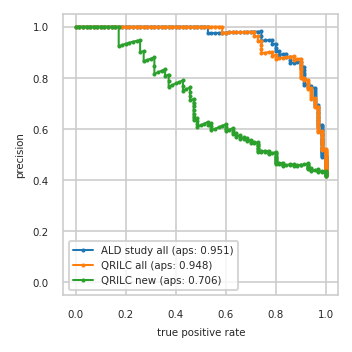

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


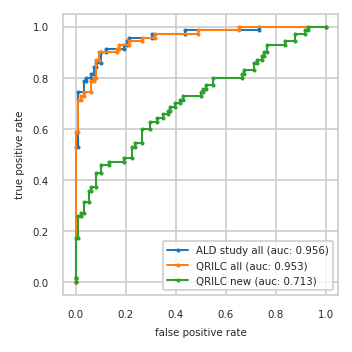

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}